# Bayesian classification


In simple terms, classification implies estimating the probability of an observation to belong to a certain class, such as positive or negative, or 0 or 1. The classical model for estimating such as probability is the Binomial model:

$$ p(y) \sim Binomial(n,p), $$

where $y$ is the number of positive cases, $n$ is the total number of trials, and $p$ is the probability of a case being positive.  

As for linear regression our likelihood model was Gaussian, here our likelihood model will be Binomial. In linear regression, we were parameterizing the mean of the Gaussian model as a linear combination of the predictors:

$$ y_i \sim \mathcal{N}(\mu_i, \sigma),$$
$$ \mu_i = a + b x_i.$$

In the Binomial model, we parameterize the probability $p$ as a linear combination of the predictors:

$$y_i \sim Binomial(n, p_i)$$
$$f(p_i) = a + b x_i.$$

There are some issues to take into account. Since the probability $p_i$ must be greater than 0 and lower than 1, by parameterizing it directly with a linear model we will incour into problems, as this would not guarantee that the linear combination is bounded in the interval $[0,1]$. Therefore we need to *link* the probability $p_i$ to the linear model through some clever parameterization, called *link function*. A classical link function is called *logit* function, and is defined with respect to the log-odds:

$$f(p_i) = logit(p_i) = \log(odds(p_i)) = \log(\frac{p_i}{1-p_i}).$$

The odds is the ratio between probability of the outcome being positive and probability of being negative. Therefore is goes from 0 ($p_i=0$) to infinity ($p_i=1$). By taking the log, we transform the odds into a quantity that can range from $-\infty$ to $\infty$, a perfect variable to be described by a linear model.
We rewrite our Binomial link function:

$$ \log(\frac{p_i}{1-p_i}) = a + b x_i,$$

and we derive:

$$\frac{p_i}{1-p_i} = \exp(a + b x_i),$$
$$p_i = \frac{\exp(a + b x_i)}{1 + \exp(a + b x_i)}. $$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, binom
import pandas as pd

%run tools.py

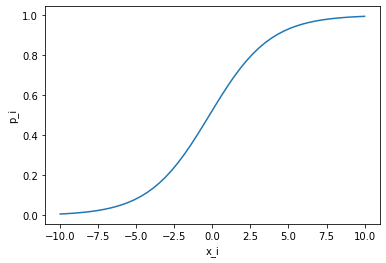

In [2]:
a = 0.1
b = 0.5

x_i = np.linspace(-10,10)

p_i = np.exp(a+b*x_i)/(1+np.exp(a+b*x_i))

plt.plot(x_i,p_i)
plt.xlabel('x_i')
plt.ylabel('p_i')
plt.show()


We recognize that the link function creates a non-linear association between $x_i$ and $p_i$, where $p_i$ is indeed bounded by 0 and 1. Importantly, although the association is linear, a unit increase in $x$ does not correspond anymore to a unit increase in the output. The magnitude of the association depends on the value of $x$ itself, and is greater in correspondence of the maximum slope of the curve. 

This kind of model is called *logistic regression*. 

## Example: Logistic regression for predicting Alzheimer's disease

In [3]:
data = pd.read_csv('adni_data')
pd.set_option('mode.chained_assignment', None) 

data_ct_ad = data.query('DX == 1 | DX == 3') 
data_ct_ad['DX'] = data_ct_ad['DX'].map({1: 0, 3: 1})

data_ct_ad['norm_brain'] = data_ct_ad['WholeBrain.bl']/data_ct_ad['ICV']
data_ct_ad['norm_brain'] = (data_ct_ad['norm_brain'] - np.mean(data_ct_ad['norm_brain']))/np.std(data_ct_ad['norm_brain'])
data_ct_ad.dropna(inplace = True)


print(data_ct_ad[:5])

   RID  APOE4  DX   AGE  WholeBrain.bl           ICV  norm_brain
0    2    0.0   0  74.3      1229738.0  1.984657e+06   -0.907716
1    3    1.0   1  81.3      1129834.0  1.920691e+06   -1.508346
3    5    0.0   0  73.7      1116633.0  1.640766e+06    0.258629
5    7    1.0   1  75.4       875798.0  1.353519e+06   -0.382669
6    8    0.0   0  84.5       948684.0  1.396068e+06    0.239182


In [4]:
import pystan

In [5]:
binomial_model_code = """
data {
  int<lower=1> N;
  int y[N];
  real x[N];
  real mu_a;
  real<lower=0> std_a;
  real mu_b;
  real<lower=0> std_b;
}
parameters {
  real a;
  real b;
}
transformed parameters {
  vector[N] p_i;
  for (i in 1:N) {
    p_i[i] = exp(a + b * x[i])/(1 + exp(a + b * x[i])); 
    }
}
model {
  b ~ normal(mu_b, std_b);
  a ~ normal(mu_a, std_a);
  y ~ binomial(1, p_i);
}
"""
model = pystan.StanModel(model_code = binomial_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_412ab0b943fbbb6e1bdcf98b815ee879 NOW.


In [6]:
data_to_stan = dict(x = data_ct_ad['norm_brain'], y = data_ct_ad['DX'], 
                    mu_a = 0, std_a = 10, mu_b = 0, std_b = 10, N = len(data_ct_ad['DX']))

fit = model.sampling(data = data_to_stan, seed = int(1), iter=4000, chains=4)

In [7]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

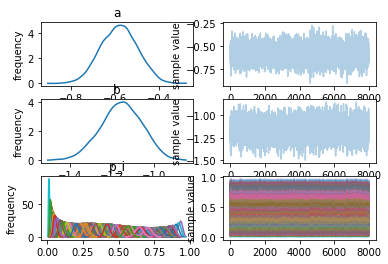

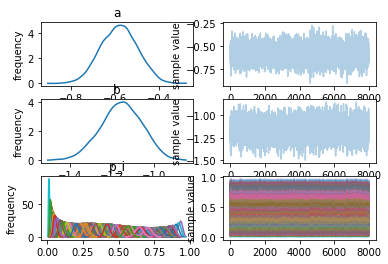

In [8]:
fit.plot()

In [9]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_412ab0b943fbbb6e1bdcf98b815ee879.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -0.58  1.1e-3   0.08  -0.74  -0.64  -0.58  -0.52  -0.42   5297    1.0
b        -1.15  1.3e-3    0.1  -1.35  -1.22  -1.15  -1.09  -0.97   5705    1.0
p_i[1]    0.61  2.9e-4   0.03   0.57    0.6   0.61   0.63   0.66   7508    1.0
p_i[2]    0.76  3.2e-4   0.03    0.7   0.74   0.76   0.78   0.81   7273    1.0
p_i[3]    0.29  2.7e-4   0.02   0.26   0.28   0.29   0.31   0.33   5007    1.0
p_i[4]    0.47  2.6e-4   0.02   0.43   0.45   0.47   0.48   0.51   6146    1.0
p_i[5]     0.3  2.7e-4   0.02   0.26   0.28    0.3   0.31   0.34   5025    1.0
p_i[6]     0.2  2.7e-4   0.02   0.17   0.19    0.2   0.22   0.24   4848    1.0
p_i[7]     0.3  2.7e-4   0.02   0.27   0.29    0.3   0.31   

In [10]:
est_a = fit.extract()['a']
quantiles_a = np.quantile(est_a, [0.05, 0.5, 0.95])

est_b = fit.extract()['b']
quantiles_b = np.quantile(est_b, [0.05, 0.5, 0.95])

logistic_a_50 = np.exp(quantiles_a[1])/(1 + np.exp(quantiles_a[1]))
logistic_a_5 = np.exp(quantiles_a[0])/(1 + np.exp(quantiles_a[0]))
logistic_a_95 = np.exp(quantiles_a[2])/(1 + np.exp(quantiles_a[2]))

print('Baseline probability of disease: \n')
print('5%  :', logistic_a_5)
print('50% :', logistic_a_50)
print('95% :', logistic_a_95)


logistic_b_95 = np.exp(quantiles_a[0] - quantiles_b[0])/(1 + np.exp(quantiles_a[0] - quantiles_b[0]))
logistic_b_50 = np.exp(quantiles_a[0] - quantiles_b[1])/(1 + np.exp(quantiles_a[0] - quantiles_b[1]))
logistic_b_5 = np.exp(quantiles_a[0] - quantiles_b[2])/(1 + np.exp(quantiles_a[0] - quantiles_b[2]))


print('Probability increase for unit decrease in standardized brain volume: \n')
print('5%  :', logistic_b_5)
print('50% :', logistic_b_50)
print('95% :', logistic_b_95)

Baseline probability of disease: 

5%  : 0.32821071829907084
50% : 0.35875565350752264
95% : 0.3906763259016573
Probability increase for unit decrease in standardized brain volume: 

5%  : 0.5695465298457103
50% : 0.6073349409823633
95% : 0.6464387666690923


In [11]:
import scipy

p_i = fit.extract()['p_i']

lppd = []
pwaic = []
for k in range(len(data_ct_ad)):
    id_log_lik = []
    for i in range(1000):
        p = np.random.choice(p_i[:,k], size = 1)
        id_log_lik.append(scipy.stats.binom.logpmf(data_ct_ad['DX'].values[k], 1, p))
    lppd.append(scipy.special.logsumexp(id_log_lik) - np.log(len(id_log_lik)))
    pwaic.append(np.var(id_log_lik))

waic = -2 * (np.sum(lppd) -np.sum(pwaic))
    
    
        

In [12]:
waic

922.4826652452281

What happens when we include another predictor, for example the presence of the genetic mutation APOE4?

In [13]:
binomial_model_two_pred_code = """
data {
  int<lower=1> N;
  int y[N];
  real x_b[N];
  real x_g[N];
  real mu_a;
  real<lower=0> std_a;
  real mu_b;
  real<lower=0> std_b;
  real mu_c;
  real<lower=0> std_c;
}
parameters {
  real a;
  real b;
  real c;
}
transformed parameters {
  vector[N] p_i;
  for (i in 1:N) {
    p_i[i] = exp(a + b * x_b[i] + c * x_g[i])/(1 + exp(a + b * x_b[i] + c * x_g[i])); 
    }
}
model {
  a ~ normal(mu_a, std_a);
  b ~ normal(mu_b, std_b);
  c ~ normal(mu_c, std_c);
  y ~ binomial(1, p_i);
}
"""
model = pystan.StanModel(model_code = binomial_model_two_pred_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c0ba10ec4a771726050e0f42751936e2 NOW.


In [14]:
data_to_stan = dict(x_b = data_ct_ad['norm_brain'], x_g = data_ct_ad['APOE4'], 
                    y = data_ct_ad['DX'], 
                    mu_a = 0, std_a = 10, mu_b = 0, std_b = 10,  mu_c = 0, std_c = 10, 
                    N = len(data_ct_ad['DX']))

fit = model.sampling(data = data_to_stan, seed = int(1), iter=4000, chains=4)

In [15]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_c0ba10ec4a771726050e0f42751936e2.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -1.48  1.9e-3   0.13  -1.73  -1.56  -1.48  -1.39  -1.23   4428    1.0
b        -1.25  1.5e-3   0.11  -1.47  -1.32  -1.25  -1.18  -1.04   5318    1.0
c         1.58  2.2e-3   0.15   1.29   1.48   1.58   1.68   1.88   4723    1.0
p_i[1]    0.41  4.3e-4   0.03   0.36   0.39   0.41   0.44   0.48   5487    1.0
p_i[2]    0.88  2.5e-4   0.02   0.84   0.86   0.88   0.89   0.91   6547    1.0
p_i[3]    0.14  2.6e-4   0.02   0.11   0.13   0.14   0.15   0.18   4373    1.0
p_i[4]    0.64  2.7e-4   0.03   0.59   0.62   0.64   0.66   0.69   9721    1.0
p_i[5]    0.15  2.6e-4   0.02   0.11   0.13   0.14   0.16   0.18   4374    1.0
p_i[6]    0.32  3.3e-4   0.03   0.27    0.3   0.32   0.34   

Is this model better fitting the diagnosis than the previous one?

In [16]:
import scipy

p_i = fit.extract()['p_i']

lppd = []
pwaic = []
for k in range(len(data_ct_ad)):
    id_log_lik = []
    for i in range(1000):
        p = np.random.choice(p_i[:,k], size = 1)
        id_log_lik.append(scipy.stats.binom.logpmf(data_ct_ad['DX'].values[k], 1, p))
    lppd.append(scipy.special.logsumexp(id_log_lik) - np.log(len(id_log_lik)))
    pwaic.append(np.var(id_log_lik))

waic = -2 * (np.sum(lppd) - np.sum(pwaic))

In [17]:
waic

782.5775769561207

## Varying intercept models

In this example we apply a more sophisticated kind of logistic regression.
The following datasets provides the admission results for males and females for 6 departments in Berkley University. The question is: is there a bias towards the admission of males?

In [18]:
data = pd.read_csv('UCBadmit.csv')

data


,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [19]:
data = pd.read_csv('UCBadmit.csv')

data['gender_int'] = np.zeros(len(data['applicant.gender']))

males = data['gender_int'][data['applicant.gender'] == 'male'].values

data.loc[data['applicant.gender'] == 'male', 'gender_int'] = 1


We run the same logistic regression model we saw before:

In [20]:
import pystan

In [21]:
binomial_model_code = """
data {
  int<lower=1> N;
  int y[N];
  int n_i[N];
  vector[N] x;
  real mu_a;
  real<lower=0> std_a;
  real mu_b;
  real<lower=0> std_b;
}
parameters {
  real a;
  real b;
}
transformed parameters {
  vector[N] p_i;
  p_i = a + b * x; 
}
model {
  b ~ normal(mu_b, std_b);
  a ~ normal(mu_a, std_a);
  y ~ binomial_logit(n_i, p_i);
}
"""
model = pystan.StanModel(model_code = binomial_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d374dc7b42939c6bc4d2b7594839d13a NOW.


In [22]:
data_to_stan = dict(x = data['gender_int'], y = data['admit'], n_i = data['applications'], 
                    mu_a = 0, std_a = 10, mu_b = 0, std_b = 10, N = 12)

fit = model.sampling(data = data_to_stan, seed = int(15), iter=1000, chains=4)

In [23]:
fit

Inference for Stan model: anon_model_d374dc7b42939c6bc4d2b7594839d13a.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -0.83  2.0e-3   0.05  -0.93  -0.87  -0.83  -0.79  -0.73    667    1.0
b         0.61  2.5e-3   0.06   0.48   0.57   0.61   0.65   0.73    656    1.0
p_i[1]   -0.22  8.9e-4   0.04   -0.3  -0.25  -0.22   -0.2  -0.15   1779    1.0
p_i[2]   -0.83  2.0e-3   0.05  -0.93  -0.87  -0.83  -0.79  -0.73    667    1.0
p_i[3]   -0.22  8.9e-4   0.04   -0.3  -0.25  -0.22   -0.2  -0.15   1779    1.0
p_i[4]   -0.83  2.0e-3   0.05  -0.93  -0.87  -0.83  -0.79  -0.73    667    1.0
p_i[5]   -0.22  8.9e-4   0.04   -0.3  -0.25  -0.22   -0.2  -0.15   1779    1.0
p_i[6]   -0.83  2.0e-3   0.05  -0.93  -0.87  -0.83  -0.79  -0.73    667    1.0
p_i[7]   -0.22  8.9e-4   0.04   -0.3  -0.25  -0.22   -0.2  -0.15   1779    1.0
p_i[8]   -0.83  2.0e-3 

Apparently the coefficient for the geneder variable is positive and significantly greater than 0. We may be tempted to conclude that there is indeed a significant bias towards males in the admission.
Let's quantify the bias:

In [24]:
def logistic(x):
    return( np.exp(x)/(1 + np.exp(x)) )

In [25]:
est_a = fit.extract()['a']
quantiles_a = np.quantile(est_a, [0.05, 0.5, 0.95])

est_b = fit.extract()['b']
quantiles_b = np.quantile(est_b, [0.05, 0.5, 0.95])


p_admit_female = logistic(est_a)
p_admit_male = logistic(est_a + est_b)


print('Probability of admission females (5%, 50%, 95%): \n')
print(np.quantile(p_admit_female, [0.05,0.5,0.95]))

print('\nProbability of admission males (5%, 50%, 95%): \n')
print(np.quantile(p_admit_male, [0.05,0.5,0.95]))

print('\nBias (5%, 50%, 95%): \n')
print(np.quantile(p_admit_male - p_admit_female, [0.05,0.5,0.95]))


Probability of admission females (5%, 50%, 95%): 

[0.28502641 0.3040003  0.32185509]

Probability of admission males (5%, 50%, 95%): 

[0.42979057 0.44521168 0.45978198]

Bias (5%, 50%, 95%): 

[0.11682088 0.14131618 0.1639281 ]


When working with this kind of models is very important to plot the modeling results and verify the meaning of models and coefficients. What would the model predict for this kind of data?

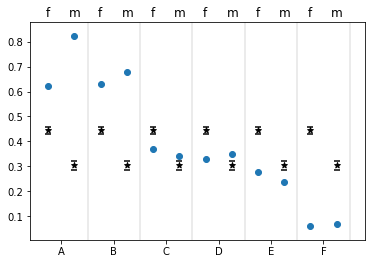

In [26]:
fig, ax = plt.subplots()
plt.scatter(range(len(data)), data['admit']/data['applications'])
locs = ax.get_xticks()
ax.set_xticks(np.arange(0.5, len(data), step=2))
ax.set_xticklabels(np.unique(data['dept']))
for i in np.arange(1.5, len(data), step=2):
    plt.axvline(x = i, color = 'black', alpha = 0.1)
    plt.text(i - 0.7, 0.9, 'm', fontsize=12)
    plt.text(i - 1.6, 0.9, 'f', fontsize=12)

    
est_p = fit.extract()['p_i']
for i in range(len(data)):
    plt.scatter(i, logistic(np.quantile(est_p[:,i], 0.5)), color = 'black', marker='*')
    plt.scatter(i, logistic(np.quantile(est_p[:,i], 0.05)), color = 'black', marker='_')
    plt.scatter(i, logistic(np.quantile(est_p[:,i], 0.95)), color = 'black', marker='_')
    
    
plt.show()





It turns out that the model is giving very similar predictions across departments. It is actually predicting an average admission rate, independently on the department. This is a problem, since is seems that different department have different admission rates, independently on the gender. Therefore we would like to account for this kind of variability across departments. Before doing so, let's compute the WAIC associated with this model:

In [27]:
p_i = fit.extract()['p_i']

lppd = []
pwaic = []
for k in range(len(data)):
    id_log_lik = []
    for i in range(1000):
        p = logistic(np.random.choice(p_i[:,k], size = 1))
        id_log_lik.append(scipy.stats.binom.logpmf(data['admit'].values[k], data['applications'].values[k], p))
    lppd.append(scipy.special.logsumexp(id_log_lik) - np.log(len(id_log_lik)))
    pwaic.append(np.var(id_log_lik))

waic = -2 * (np.sum(lppd) - np.sum(pwaic))

In [28]:
print(waic)

993.5806574242562


To include the department information in the model we need to encode the corresponding the numerical values:

In [29]:
data.replace('A',1, inplace=True)
data.replace('B',2, inplace=True)
data.replace('C',3, inplace=True)
data.replace('D',4, inplace=True)
data.replace('E',5, inplace=True)
data.replace('F',6, inplace=True)
data

,dept,applicant.gender,admit,reject,applications,gender_int
1,1,male,512,313,825,1.0
2,1,female,89,19,108,0.0
3,2,male,353,207,560,1.0
4,2,female,17,8,25,0.0
5,3,male,120,205,325,1.0
6,3,female,202,391,593,0.0
7,4,male,138,279,417,1.0
8,4,female,131,244,375,0.0
9,5,male,53,138,191,1.0
10,5,female,94,299,393,0.0


In our new logistic regression model with varying intercepts the logistic link will take the form:


$$logit(\pi) = a_i + b x_i,$$

where $a_i$ is a parameters that varies across departments. In practice, for every department we have a different interecept that we want to estimate.

In [30]:
binomial_model_varying_intercept_code = """
data {
  int<lower=1> N;
  int y[N];
  int n_i[N];
  vector[N] x;
  int dept_id_max;
  int<lower = 1, upper = dept_id_max> dept_id[N];
  real mu_a;
  real<lower=0> std_a;
  real mu_b;
  real<lower=0> std_b;
}
parameters {
  vector[dept_id_max] a;
  real b;
}
transformed parameters {
  vector[N] p_i;
  p_i = b * x; 
  for (i in 1:N) {
    p_i[i] = a[dept_id[i]] + b * x[i]; 
    }
}
model {
  b ~ normal(mu_b, std_b);
  a ~ normal(mu_a, std_a);
  y ~ binomial_logit(n_i, p_i);
}
"""
model = pystan.StanModel(model_code = binomial_model_varying_intercept_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0aef0fc19dc158c45f3505408b0c8bec NOW.


In [31]:
data_to_stan = dict(x = data['gender_int'], y = data['admit'], n_i = data['applications'], 
                    dept_id_max = np.max(data['dept'].values), dept_id = data['dept'],
                    mu_a = 0, std_a = 10, mu_b = 0, std_b = 10, N = 12)

fit = model.sampling(data = data_to_stan, seed = int(15), iter=1000, chains=4)

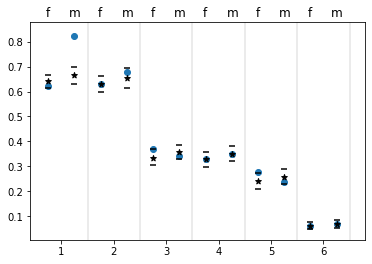

In [32]:
fig, ax = plt.subplots()
plt.scatter(range(len(data)), data['admit']/data['applications'])
locs = ax.get_xticks()
ax.set_xticks(np.arange(0.5, len(data), step=2))
ax.set_xticklabels(np.unique(data['dept']))
for i in np.arange(1.5, len(data), step=2):
    plt.axvline(x = i, color = 'black', alpha = 0.1)
    plt.text(i - 0.7, 0.9, 'm', fontsize=12)
    plt.text(i - 1.6, 0.9, 'f', fontsize=12)

    
est_p = fit.extract()['p_i']
for i in range(len(data)):
    plt.scatter(i, logistic(np.quantile(est_p[:,i], 0.5)), color = 'black', marker='*')
    plt.scatter(i, logistic(np.quantile(est_p[:,i], 0.05)), color = 'black', marker='_')
    plt.scatter(i, logistic(np.quantile(est_p[:,i], 0.95)), color = 'black', marker='_')
    
    
plt.show()

We see that now the model does a much better job in predicting the variability of admission across departments. In particular, the coefficient accounting for the gender difference is much closer to zero. Therefore gender bias is not supported by this model.

In [33]:
fit

Inference for Stan model: anon_model_0aef0fc19dc158c45f3505408b0c8bec.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[1]      0.68  3.0e-3    0.1    0.5   0.62   0.69   0.75   0.88   1074    1.0
a[2]      0.64  3.3e-3   0.11   0.43   0.57   0.64   0.72   0.87   1169    1.0
a[3]     -0.58  1.9e-3   0.07  -0.74  -0.63  -0.58  -0.53  -0.44   1476    1.0
a[4]     -0.61  2.3e-3   0.09  -0.78  -0.67  -0.61  -0.55  -0.45   1398    1.0
a[5]     -1.05  2.5e-3    0.1  -1.25  -1.12  -1.05  -0.99  -0.87   1561    1.0
a[6]     -2.63  4.4e-3   0.16  -2.95  -2.73  -2.63  -2.52  -2.34   1316    1.0
b         -0.1  2.7e-3   0.08  -0.26  -0.16   -0.1  -0.05   0.05    846    1.0
p_i[1]    0.58  1.3e-3   0.07   0.45   0.54   0.58   0.63   0.72   2940    1.0
p_i[2]    0.68  3.0e-3    0.1    0.5   0.62   0.69   0.75   0.88   1074    1.0
p_i[3]    0.54  1.6e-3 

Is the model better than the previous one in terms of WAIC? In theory it should be penalized since we have now more parameters.

In [34]:
p_i = fit.extract()['p_i']

lppd = []
pwaic = []
for k in range(len(data)):
    id_log_lik = []
    for i in range(1000):
        p = logistic(np.random.choice(p_i[:,k], size = 1))
        id_log_lik.append(scipy.stats.binom.logpmf(data['admit'].values[k], data['applications'].values[k], p))
    lppd.append(scipy.special.logsumexp(id_log_lik) - np.log(len(id_log_lik)))
    pwaic.append(np.var(id_log_lik))

waic = -2 * (np.sum(lppd) - np.sum(pwaic))

In [35]:
print(waic)

108.74731015125035


## Poisson Model

The application of a Poisson model is when a Binomial variable has a small probability $p$ for an event and a very large number $N$ of trials. Poisson distribution allows us to model binomial events (counts) for which the number of trials is unknown, or uncountably large.

The Poisson model has only one parameter, that we call $\lambda$, that represents the epected value for the observation of an event. Each observation $y_i$ is then distributed as:

$$y_i \sim Poisson(\lambda),$$

where 

$$ p(y_i | \lambda) = \frac{\exp(-\lambda) \lambda^y}{y!}.$$

In a regression setting, we would like to quantify to what extent  the appeareance of an event relates to an explanatory variable $x$. Similarly as with the Binomial case, we need to ensure that $\lambda$ is positive, since it represents a count rate. We can use again a suitable link function, which guarantess this constraint. A classical link function in this case is a $\log$ link:

$$ y_i \sim Poisson(\lambda_i),$$
$$ \log(\lambda_i) = \alpha + \beta x_i.$$


 

## Example

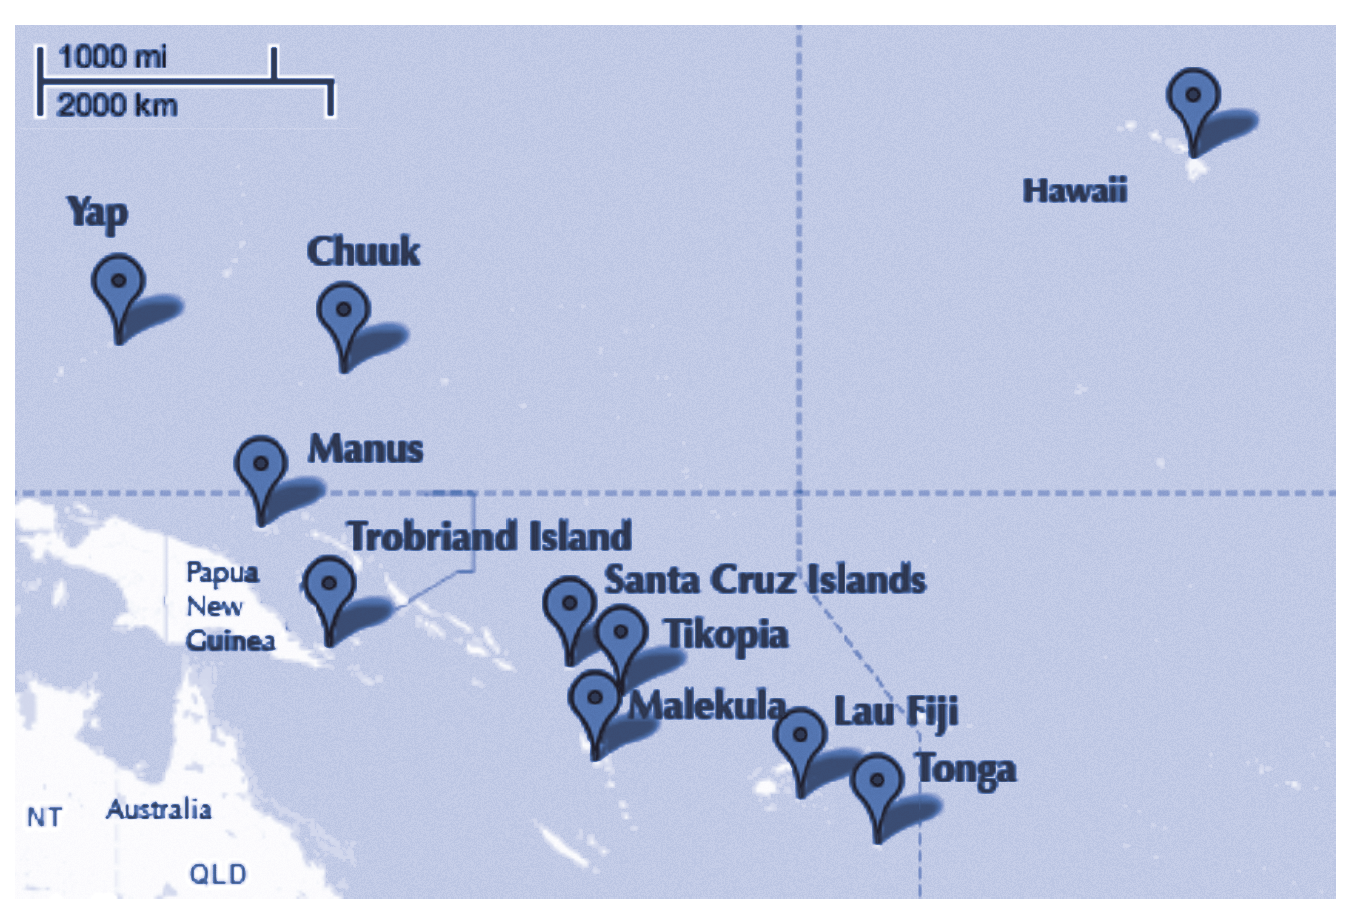

In [36]:
island_data = pd.read_csv('Kline')
island_data

,Unnamed: 0,culture,population,contact,total_tools,mean_TU
0,1,Malekula,1100,low,13,3.2
1,2,Tikopia,1500,low,22,4.7
2,3,Santa Cruz,3600,low,24,4.0
3,4,Yap,4791,high,43,5.0
4,5,Lau Fiji,7400,high,33,5.0
5,6,Trobriand,8000,high,19,4.0
6,7,Chuuk,9200,high,40,3.8
7,8,Manus,13000,low,28,6.6
8,9,Tonga,17500,high,55,5.4
9,10,Hawaii,275000,low,71,6.6


We want to model whether the number of tools that populations developed in their history (such as fish hooks, axes, boats):

- increases with population size, 

- increases with the contact rate with other populations, 

- increases in large populations with large contact rate.

The model we want to fit is therefore of this kind:

$$ {tools}_i \sim Poisson(\lambda_i), $$
$$ \log(\lambda_i) = a + b * \log(\mbox{pop_size}_i) + c * \mbox{count_rate}_i + d * \log(\mbox{pop_size}_i) * \mbox{cont_rate}_i,$$
$$ a \sim Normal(0,100)$$
$$ b \sim Normal(0,1)$$
$$ c \sim Normal(0,1)$$
$$ d \sim Normal(0,1)$$


In [37]:
island_data['contact'] = island_data['contact'].map({'low': 0, 'high': 1})

island_data['log_population'] = np.log(island_data['population'])

island_data['log_population_c'] = (island_data['log_population'] - np.mean(island_data['log_population']))/np.std(island_data['log_population'])

In [38]:
poisson_model_1_code = """
data {
  int<lower=1> N;
  int y[N];
  real log_pop_size[N];
  real cont_rate[N];
}
parameters {
  real a;
  real b;
  real c;
  real d;
}
transformed parameters {
  vector[N] lambda_i;
  for (i in 1:N) {
    lambda_i[i] = exp(a + b * log_pop_size[i] + c * cont_rate[i] + d * log_pop_size[i] * cont_rate[i]);
    }
}
model {
  a ~ normal(0, 100);
  b ~ normal(1, 1);
  c ~ normal(0, 1);
  d ~ normal(0, 1);
  y ~ poisson(lambda_i);
}
"""
model_interaction = pystan.StanModel(model_code = poisson_model_1_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1956b3cd5b963550504342ce33556b2d NOW.


In [39]:
data_to_stan = dict(log_pop_size = island_data['log_population_c'], cont_rate = island_data['contact'],
                    y = island_data['total_tools'],  
                    N = len(island_data))

fit_interaction = model_interaction.sampling(data = data_to_stan, seed = int(1), iter=1000, chains=4)

In [40]:
fit_interaction

Inference for Stan model: anon_model_1956b3cd5b963550504342ce33556b2d.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a              3.31  2.8e-3   0.09   3.14   3.25   3.31   3.37   3.48    988    1.0
b              0.38  1.4e-3   0.05   0.29   0.35   0.38   0.42   0.48   1342    1.0
c              0.29  3.6e-3   0.11   0.07   0.22   0.29   0.37   0.51    977    1.0
d              0.09  5.9e-3   0.24  -0.39  -0.06    0.1   0.25   0.55   1611    1.0
lambda_i[1]   16.33    0.07    2.2  12.55  14.81  16.16  17.63  21.21    923    1.0
lambda_i[2]   17.71    0.07   2.23  13.84  16.15  17.53  19.04   22.6    912    1.0
lambda_i[3]   22.28    0.08   2.32  18.19  20.65  22.15  23.75  27.23    912    1.0
lambda_i[4]   31.16     0.1   3.91   24.2  28.39  31.03  33.58  39.59   1664    1.0
lambda_i[5]   35.79    0.07   2.84  30.53  33.78  35.72  

While the coefficients for the total population (b) and the contact rate are (c) are positive an consistently greater than zero. What is the effect of contact rate on the number of tools expected to be produced by a population. Let's explore the counterfactuals for two populations with same population size (say equal to 0.5 standard deviations in the standardized log-population size), but one with low and one with high contact rate. 

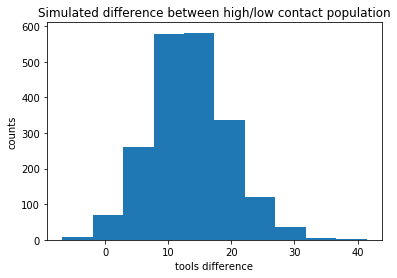

In [41]:
post_a_int = fit_interaction.extract()['a']
post_b_int = fit_interaction.extract()['b']
post_c_int = fit_interaction.extract()['c']
post_d_int = fit_interaction.extract()['d']

log_pop_size = 0.5

simul_low_cont = np.exp(post_a_int + post_b_int * log_pop_size)
simul_high_cont = np.exp(post_a_int + post_b_int * log_pop_size + post_c_int + post_d_int * log_pop_size)

plt.hist(simul_high_cont - simul_low_cont)
plt.title('Simulated difference between high/low contact population')
plt.xlabel('tools difference')
plt.ylabel('counts')
plt.show()


We note that the difference between the simulated number of tools is significantly greater the zero, and peaked around 15.

In the model above, we aleo note that the coefficient associated to interaction term (d) is close to zero and with confidence margin including zero itself. Can we conclude that there is no interaction? 
Let's explore another model where the interaction term is omitted, and let's perform some model comparison.
We first compute the WAIC for the current model.

In [42]:
lambda_i = fit_interaction.extract()['lambda_i']

lppd = []
pwaic = []
for k in range(len(island_data)):
    id_log_lik = []
    for i in range(1000):
        p = logistic(np.random.choice(lambda_i[:,k], size = 1))
        id_log_lik.append(scipy.stats.poisson.logpmf(island_data['total_tools'][k], p))
    lppd.append(scipy.special.logsumexp(id_log_lik) - np.log(len(id_log_lik)))
    pwaic.append(np.var(id_log_lik))

waic_interact = -2 * (np.sum(lppd) - np.sum(pwaic))

In [43]:
waic_interact

1925.9501349763652

Now let's fit a model without interaction:

In [44]:
poisson_model_2_code = """
data {
  int<lower=1> N;
  int y[N];
  real log_pop_size[N];
  real cont_rate[N];
}
parameters {
  real a;
  real b;
  real c;
}
transformed parameters {
  vector[N] lambda_i;
  for (i in 1:N) {
    lambda_i[i] = exp(a + b * log_pop_size[i] + c * cont_rate[i] );
    }
}
model {
  a ~ normal(0, 100);
  b ~ normal(1, 1);
  c ~ normal(0, 1);
  y ~ poisson(lambda_i);
}
"""
model_no_interaction = pystan.StanModel(model_code = poisson_model_2_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dc6931a98915c7d76ea9791e7241b4a4 NOW.


In [45]:
data_to_stan = dict(log_pop_size = island_data['log_population_c'], cont_rate = island_data['contact'],
                    y = island_data['total_tools'],  
                    N = len(island_data))

fit_no_int = model_no_interaction.sampling(data = data_to_stan, seed = int(1), iter=1000, chains=4)

In [46]:
fit_no_int

Inference for Stan model: anon_model_dc6931a98915c7d76ea9791e7241b4a4.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a               3.3  2.9e-3   0.09   3.12   3.25   3.31   3.36   3.47    890   1.01
b              0.39  1.5e-3   0.05   0.29   0.36   0.39   0.42   0.48   1035   1.01
c               0.3  3.6e-3   0.11    0.1   0.23    0.3   0.37   0.53    908   1.01
lambda_i[1]   16.15    0.07   2.07  12.16  14.75  16.03  17.49  20.52    802   1.01
lambda_i[2]   17.54    0.07   2.11  13.41  16.13  17.42  18.92   21.9    804   1.01
lambda_i[3]   22.13    0.08   2.22   17.7   20.7  22.05  23.57  26.56    833   1.01
lambda_i[4]   32.29    0.05    2.4  27.74  30.65  32.21  33.81  37.25   2463    1.0
lambda_i[5]   36.27    0.05   2.61  31.27  34.46  36.21  37.91  41.72   2455    1.0
lambda_i[6]   37.04    0.05   2.66  31.94   35.2  36.97  

In [47]:
post_a_no_int = fit_no_int.extract()['a']
post_b_no_int = fit_no_int.extract()['b']
post_c_no_int = fit_no_int.extract()['c']

In [48]:
lambda_i = fit_no_int.extract()['lambda_i']

lppd = []
pwaic = []
for k in range(len(island_data)):
    id_log_lik = []
    for i in range(1000):
        p = logistic(np.random.choice(lambda_i[:,k], size = 1))
        id_log_lik.append(scipy.stats.poisson.logpmf(island_data['total_tools'][k], p))
    lppd.append(scipy.special.logsumexp(id_log_lik) - np.log(len(id_log_lik)))
    pwaic.append(np.var(id_log_lik))

waic_no_interact = -2 * (np.sum(lppd) - np.sum(pwaic))

In [49]:
waic_no_interact

1925.9501416401754

The model without interaction has very similar WAIC than the one with interaction. This information supports the fact the interaction term is not really necessary. How would this new model predict the tools counts?

In [54]:
low_cont_no_inter = []
high_cont_no_inter = []
for log_p_c in np.linspace(-1.5,1.5):    
    # No interaction model
    low_cont_no_inter.append(np.exp(post_a_no_int + post_b_no_int * log_p_c))
    high_cont_no_inter.append(np.exp(post_a_no_int + post_b_no_int * log_p_c + post_c_no_int ))

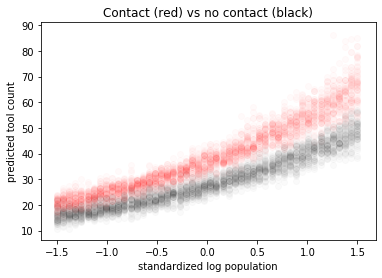

In [55]:
for i,log_p_c in enumerate(np.linspace(-1.5,1.5)):
    for k in np.random.choice(low_cont_no_inter[i],50):
        plt.scatter(log_p_c,k, color = 'black', alpha = 0.02)
    for k in np.random.choice(high_cont_no_inter[i],50):
        plt.scatter(log_p_c,k, color = 'red', alpha = 0.02)

plt.xlabel('standardized log population')        
plt.ylabel('predicted tool count')
plt.title('Contact (red) vs no contact (black)')
plt.show()

## Offest in Poisson model

Recalling that $\lambda_i$ is a count rate, often we have to express it as a ratio between observed number of events, $\mu_i$, and related time interval $\tau_i$: 

$$ \lambda_i = \frac{\mu_i}{\tau_i}. $$

In this setting the Poisson regression can be written as 

$$ \log(\lambda_i) = \log(\frac{\mu_i}{\tau_i}) = \alpha + \beta x_i,$$

which implies 

$$ \log(\mu_i) - \log({\tau_i}) = \alpha + \beta x_i,$$ 

and

$$ \log(\mu_i) = \log({\tau_i}) + \alpha + \beta x_i.$$ 


In particular, the offset $\tau_i$ scales the Poisson ratio according to the considered time interval. In practice, we can consider $\mu_i$ as the exptected ratio that we want to infer in our Poisson model, and $\tau_i$ as an additional modulating factor:

$$y_i \sim Poisson(\mu_i),$$
$$ \log(\mu_i) = \log(\tau_i) + \alpha + \beta x_i.$$

Let's explore this effect with an example. We want to evaluate the productivity between two companies in selling contracts. We suppose that company 1 records sales activity (number of contracts) on a daily basis, while company 2 records the contracts weekly. 

We generate this data, and we impose a ground truth where the average daily contracts for company 1 is 1.5, while for company 2 is 0.5.  

In [56]:
N_days = 30

# contrats rate per day
success_rate_1 = 1.5

# simulating contrats over 30 days
contracts_1 = scipy.stats.poisson.rvs( success_rate_1, size =  N_days)

In [57]:
contracts_1

array([1, 3, 1, 3, 2, 0, 2, 3, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 3, 0, 1,
       2, 1, 1, 3, 6, 2, 2, 2])

In [59]:
N_weeks = 4

# contrats rate per day of new company 
success_rate_2 = 0.5

# simulating weekly contracts
contracts_2 = scipy.stats.poisson.rvs( success_rate_2 * 7, size =  N_weeks)

In [60]:
contracts_2

array([2, 4, 2, 4])

In [61]:
# Assmbling input data

tot_constracts = np.hstack([contracts_1, contracts_2])

time = np.hstack([np.repeat(1,N_days), np.repeat(7,N_weeks)])
company = np.hstack([np.repeat(0,N_days), np.repeat(1,N_weeks)])

We are now going to fit a model for establishing is there is any difference in production between the two companies. We know that we sould expect a difference, although measures are on a different scale (days vs weeks). 

In [62]:
poisson_model_offset_code = """
data {
  int<lower=1> N;
  int y[N];
  real company[N];
  real offset[N];
}
parameters {
  real a;
  real b;
}
transformed parameters {
  vector[N] lambda_i;
  for (i in 1:N) {
    lambda_i[i] = exp( log(offset[i]) + a + b * company[i] );
    }
}
model {
  a ~ normal(0, 100);
  b ~ normal(0, 1);
  y ~ poisson(lambda_i);
}
"""
model_offset = pystan.StanModel(model_code = poisson_model_offset_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2eed4079a1c8828ab2dd67e7eceaed24 NOW.


In [63]:
data_to_stan = dict(offset = time, company = company,
                    y =  tot_constracts,
                    N = len(tot_constracts))

fit_no_int = model_offset.sampling(data = data_to_stan, seed = int(1), iter=1000, chains=4)

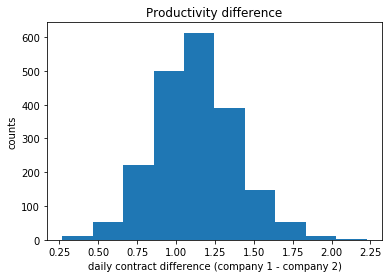

In [64]:
post_a = fit_no_int.extract()['a']
post_b = fit_no_int.extract()['b']

expected_production_company1 = np.exp(post_a) 
expected_production_company2 = np.exp(post_a + post_b) 

plt.hist(expected_production_company1 - expected_production_company2)
plt.title('Productivity difference')
plt.xlabel('daily contract difference (company 1 - company 2)')
plt.ylabel('counts')
plt.show()

## Relationship between Poisson and Binomial

The Poisson distribution is a psecial case of the Binomial one. 

In [65]:
data = pd.read_csv('UCBadmit.csv')

data['gender_int'] = np.zeros(len(data['applicant.gender']))

males = data['gender_int'][data['applicant.gender'] == 'male'].values

data.loc[data['applicant.gender'] == 'male', 'gender_int'] = 1



In [66]:
binomial_model_code = """
data {
  int<lower=1> N;
  int y[N];
  int n_i[N];
  real mu_a;
  real<lower=0> std_a;
}
parameters {
  real a;
}
transformed parameters {
  vector[N] p_i;
  for (i in 1:N) {
     p_i[i] = a ; 
  }
}
model {
  a ~ normal(mu_a, std_a);
  y ~ binomial_logit(n_i, p_i);
}
"""
model = pystan.StanModel(model_code = binomial_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ccdd3c0cde37f813c7801ddebef1668c NOW.


In [67]:
data_to_stan = dict( y = data['admit'], n_i = data['applications'], 
                    mu_a = 0, std_a = 10, N = 12)

fit = model.sampling(data = data_to_stan, seed = int(15), iter=1000, chains=4)


avg_p = np.mean(logistic(fit.extract()['a']))
print('Average probability of admission computed by the Binomi:al model: ', avg_p)


Average probability of admission computed by the Binomi:al model:  0.3880245828307227


In [68]:
poisson_model_code = """
data {
  int<lower=1> N;
  int adm[N];
  int rej[N];
}
parameters {
  real a;
  real b;
}
transformed parameters {
  vector[N] lambda_success_i;
  vector[N] lambda_failure_i;
  for (i in 1:N) {
    lambda_success_i[i] = exp(a);
    lambda_failure_i[i] = exp(b);
    }
}
model {
   a ~ normal(0, 100);
   b ~ normal(0, 100);
   rej ~ poisson(lambda_failure_i);
   adm ~ poisson(lambda_success_i);
}
"""
model_poisson = pystan.StanModel(model_code = poisson_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_14e5e5784c9d56bde0b94359e91a2791 NOW.


In [69]:
data_to_stan = dict( adm = data['admit'], rej = data['reject'], N = len(data))

fit = model_poisson.sampling(data = data_to_stan, seed = int(15), iter=1000, chains=4)

The probability of success can be computed as the ratio of positive outcome relative to number of total outcomes (positive + negative):

$$ p_{success} = \frac{\lambda_{success}}{\lambda_{success} + \lambda_{failure}} $$

In [70]:
avg_p_poisson = np.mean(np.exp(fit.extract()['a'])/(np.exp(fit.extract()['a'])+np.exp(fit.extract()['b'])))
print('Average probability of admission computed by the Poisson model: ', avg_p_poisson)

Average probability of admission computed by the Poisson model:  0.38774724919690173


As an extension, a Poisson model can be turned into a Multinomial one just by modeling independently the success rate of each category, and then by computing the associated probabilities $p_i$ via a *softmax* of the rates $\lambda_i$.